In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

In [2]:
model = ResNet50(weights='imagenet')

img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [12]:
as_list = [l.tolist() for l in model.get_weights()]
model_weights = [np.array(w) for w in as_list]

for a in range(len(model_weights)):
    assert model.get_weights()[a].all() == model_weights[a].all()

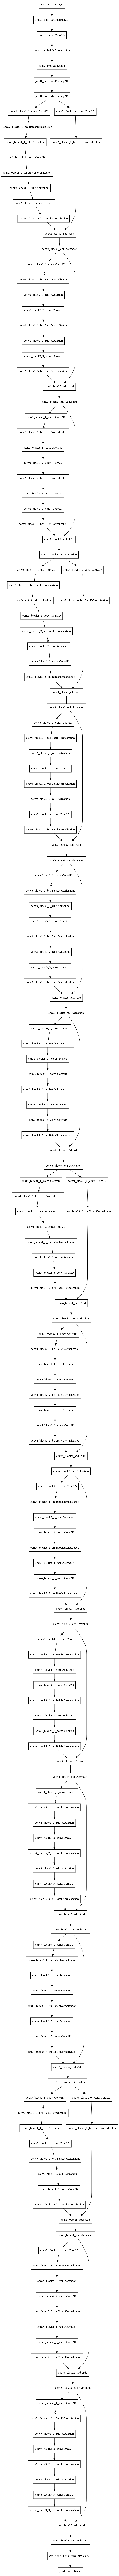

In [4]:
tf.keras.utils.plot_model(model, "resnet.png", show_shapes=False)

Base case at pool1_pool
Base case at part_begin
Base case at part_begin
Base case at part_begin


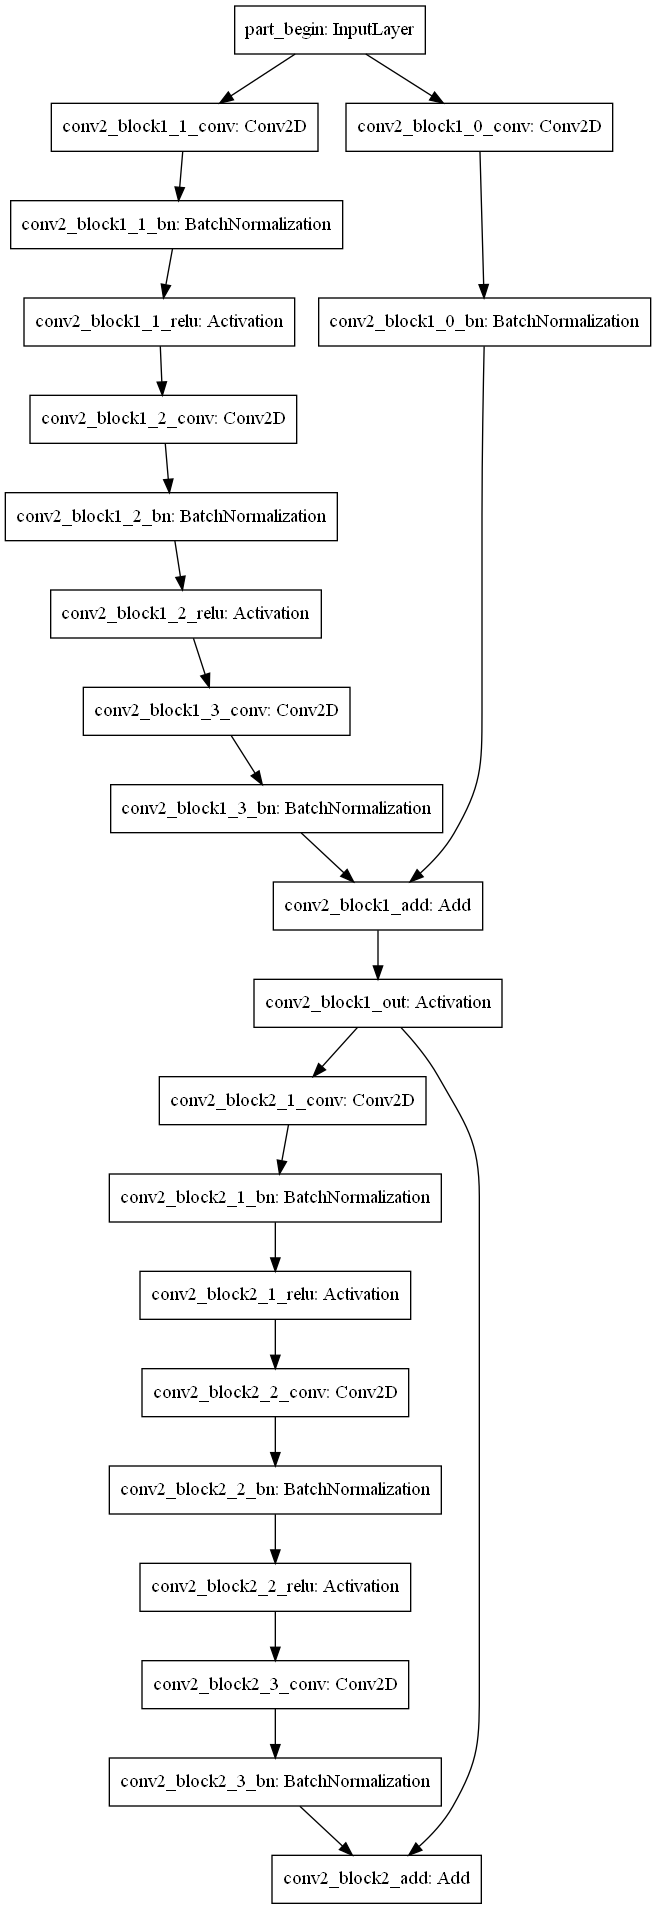

In [5]:
def get_previous(name):
    inbound = model.get_layer(name).inbound_nodes[0].inbound_layers
    if type(inbound) != list:
        inbound = [inbound]
    return [layer.name for layer in inbound]

def traverse(name):
    # On subsequent recursive steps, the new input layer will be defined, 
    # so that name needs to be checked in base case
    if (name == start_layer) or (name == part_name):
        print("Base case at", name)
        return tf.keras.Input(tensor=model.get_layer(start_layer).output, name=part_name)

    output = []
    for n in get_previous(name):
        output.append(traverse(n))
    
    # If the DAG node only has 1 previous connection
    if len(output) == 1:
        output = output[0]
    
    layer = model.get_layer(name)
    to_next = layer(output)
    return to_next

start_layer = "input1"
end_layer = "conv4_block2_add"
part_name = "part_begin" 
output = traverse(end_layer)
part_test = tf.keras.Model(inputs=model.get_layer(start_layer).output, outputs=output)
tf.keras.utils.plot_model(part_test, "dag_part1.png")

In [8]:
print(model.output._keras_history.layer.name)

predictions


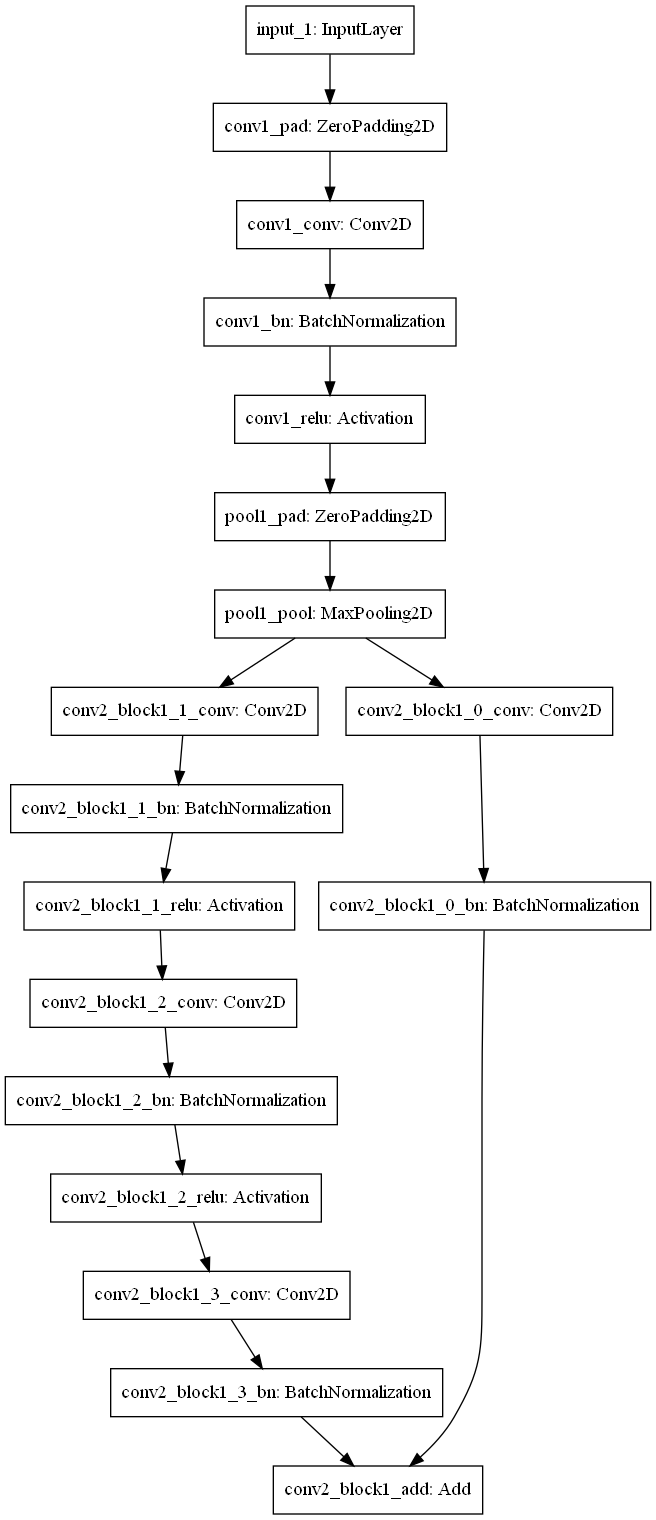

In [121]:
p1 = tf.keras.Model(inputs=model.input, outputs=model.get_layer(end_layer).output)
tf.keras.utils.plot_model(p1)

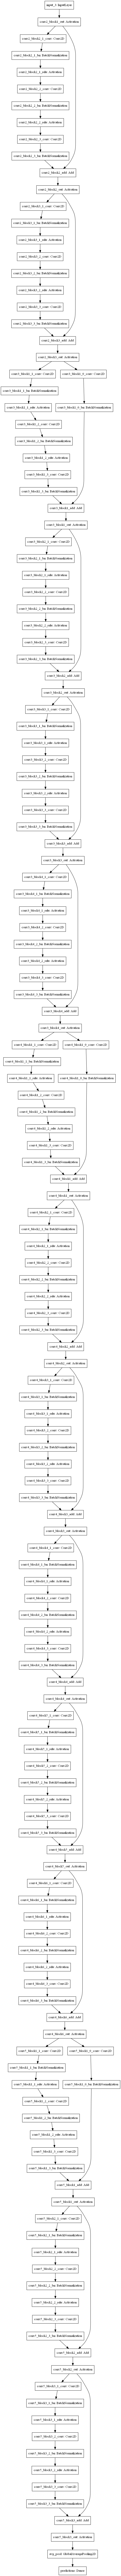

In [122]:
p2 = tf.keras.Model(inputs=tf.keras.Input(tensor=p1.output), outputs=model.output)
tf.keras.utils.plot_model(p2)

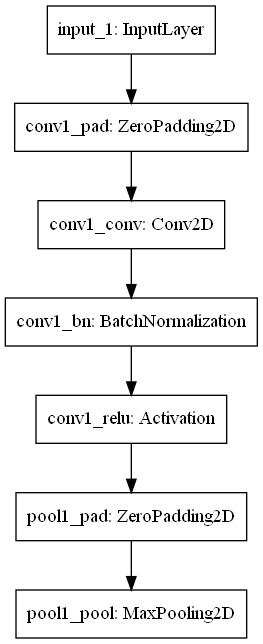

In [107]:
part = tf.keras.Model(inputs=model.input, outputs=output)
tf.keras.utils.plot_model(part, "part.png")

In [10]:
print([layer.name for layer in model.layers])

['input_1', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_2_bn', 'conv3_block1_2_relu', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block1_0_bn', 'conv3_bl

In [5]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02113799', 'standard_poodle', 0.3148437), ('n01871265', 'tusker', 0.28991377), ('n02504013', 'Indian_elephant', 0.18598309)]
